Lab作业3： 朴素贝叶斯
12011404@mail.sustech.edu.cn 叶璨铭
1. 朴素贝叶斯算法笔记
1.1 贝叶斯定理
$$P(y|x) = P(y, x)/P(x) = P(x|y)P(y) / P(x)$$
y是分类输出。后验概率可以被用于最小化决策错误率。
> 后验概率函数的理解是给定x，遍历所有y，可以得到多个概率。
> P(y,x)则是联合概率，这里计算式子x是固定的，但是也适用于多个x，二元函数。
> 但是x定了之后，就是x，y一起出现的概率行不行了。x本身多大只是调节。
> 当然x给定的概率和x,y一起出现的概率不是一个意思。而且有很大的差别。这一点总是让人混淆。

- P(x)对于分类决策无用。决策时必然已知x，决策依据是给定x后y的概率，此时所有y的证据P(x)都一样。
- 大数定律可以保证对样本的频率依概率收敛到概率，先验概率P(y)比较好估计。
- P(x|y)就比较难估计，因为x维度比较大，出现的情况比y少，比如有d维，那么就算x是二值的，也最少需要$2^d$个数据才能开始统计。简单说来就是出现具体的一个x向量的联合概率太低了，样本量很难那么大。

1.2 贝叶斯分类器

1.3 高斯朴素贝叶斯分类器
1.4 0时条件概率计算


## 2 朴素贝叶斯算法实现
文本信息挖掘的应用包括情感（sentiment）分析、文档（document）分类、话题分类、文本总结、机器翻译等。

### 2.1 垃圾邮件（Spam）过滤

> 单词考据：spam是午餐肉，ham是火腿。认为火腿比午餐肉好吃。其实不应该这种非正式的词语当学术名词，垃圾邮件正确翻译是junk mail，正常邮件是normal mail。

垃圾邮件过滤是文档分类的一种。
1. 准备文本数据。
2. 创建单词本
3. 提取特征
4. 实现算法
5. 训练算法
6. 测试算法

### 1. 准备文本数据。
训练集702，测试集260，一半垃圾一半正常，垃圾的文件名有'spmsg'。文本清洗是指去除与决策无关的（undesirable）单词，比如标点、停用词、数字。 有个语料库(corpus)是这样做的

1. **去除“停用词”（Stop Words）** “停用词”是一个错误的中文翻译。“停用词”并没有被任何人“停用”、“禁止使用”或者现在已经“不再使用”，恰恰相反，“停用词”是语言中最常用、很多人都在用、很多语句都必须使用的词。正是因为太常用了，出现概率高，根据信息论，其提供的信息比较少，所以忽略了。实际上英文“Stop”不是“停下、阻碍”的意思，是“停顿（以便连接）、中断（以便继续）”，应当翻译为“连接词”或者“功能词”。

2. **词形还原（Lemmatization）** 把英语语法要求的一些单词变形视作是同一个原型来理解，因为确实是一个语义。

3. **标点符号（punctuation）和特殊符号去除** 标点符号也是出现太多次了。特殊符号是太少出现了？为什么要去除呢？

### 2. 创建单词本
获得单词和其出现频率，可以用Counter(List of words)得到一个类似字典word:count的对象。
isalpha()可以判断字符串是不是只有A-Z,a-z。
most_common(3000)可以提取前3000.

In [1]:
# To show the most frequent words in train-mails
from collections import Counter
def make_dictionary(path):
    emails = [os.path.join(path,f) for f in os.listdir(path)]
    all_words = []
    for mail in emails:
        with open(mail) as m:
            for i,line in enumerate(m):
                if i == 2: # Body of email is only 3rd line of text file
                    words = line.split()
                    all_words += words
    return Counter(all_words)
dictionary = make_dictionary('ling-spam/train-mails')
dictionary = dict(filter(lambda x:x[0].isalpha() and len(x[0])!=1, dictionary.items()))
dictionary = Counter(dictionary).most_common(3000)
dictionary[:5]

[('order', 1414),
 ('address', 1293),
 ('report', 1216),
 ('mail', 1127),
 ('send', 1079)]

### 3. 提取特征
这里我们把一个文本（多个句子，多个单词）映射为一个固定的3000维向量。第i维数值的大小是出现频率第i高的单词在文本中出现的次数。这样的向量称为词袋模型（bag of words）。
比如，“凄凄惨惨戚戚”就是3000维里面大部分都是0，只有“凄”、“惨”、“戚”三个词的值是2。

接下来产生 702x3000矩阵，表示700个训练数据的特征向量。

In [2]:
import os
import numpy as np
def extract_features(mail_dir):
    files = [os.path.join(mail_dir,fi) for fi in os.listdir(mail_dir)]
    features_matrix = np.zeros((len(files),3000))
    docID = 0
    _i = 0
    print(len(files))
    for fil in files:
        _i+=1
        with open(fil) as fi:
            for i,line in enumerate(fi):
                if i == 2:
                    words = line.split()
                    for word in words:
                        wordID = 0
                        for i,d in enumerate(dictionary):
                            if d[0] == word:
                                wordID = i
                                features_matrix[docID,wordID]+=1
            docID = docID + 1
        print('\r','done {} files'.format(_i),flush=True,end='')
    return features_matrix

In [3]:
# Create a dictionary of words with its frequency
features_matrix = extract_features("ling-spam/train-mails")
features_matrix

702
 done 702 files

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [4]:
print(features_matrix.shape)
print(features_matrix[:, 0].sum())
print(features_matrix[:, -1].sum())

(702, 3000)
1414.0
8.0


In [5]:
test_matrix = extract_features("ling-spam/test-mails")
test_matrix[:, :5]

260
 done 260 files

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [17.,  2.,  0.,  5.,  0.]])

### 4) Training the Classifiers
Here you should write your Naïve Bayes classifiers after fully understanding its principle.

In [6]:
def get_label(path):
    """find whether the mail is spam or not. Returns a list of labels. """
    emails = [os.path.join(path,f) for f in os.listdir(path)]
    y_label = []
    for email in emails:
        y_label.append(1 if 'spmsg' in email else 0)
    return y_label

In [7]:
########### Write Your Code Here ###########
# Prepare feature vectors per training mail and its labels
X_train = features_matrix
y_train = get_label("ling-spam/train-mails")
############################################
X_train.shape, len(y_train)

((702, 3000), 702)

In [8]:
########### Write Your Code Here ###########
# Prepare feature vectors per testing mail and its labels
X_test = test_matrix
y_test = get_label("ling-spam/test-mails")
############################################
X_test.shape, len(y_test)

((260, 3000), 260)

In [9]:
sum(y_train), sum(y_test)

(351, 130)

In [11]:
np.unique(y_train)

array([0, 1])

### 5) Implementation of the Naive Bayes algorithm

Complete the code for naive Bayes algorithm in `predict` function.


In [27]:

########### Write Your Code Here ###########
class NaiveBayes():
    def __init__(self, epsilon=1e-1):
      self.epsilon = epsilon
      self.parameters = {}
      self.classes_ = []
    def fit(self, X, y):
        # var出现0的时候有很大问题，模型会认为这个特征必须是某个值，其他值就以为一定不是这个类。
        # 为了避免这个问题，我们可以在var上加一个很小的值，但是怎么加不能乱搞。
        # 主要考虑两个问题
        # 1. 不同特征之间的公平性。
        # 2. 不同类别之间的公平性。
        # 首先，原本的公式是对的，本质上只不过是我们样本量不够，所以才让模型不适用，方差为0。
        # 最终我们考虑的是P(x1|c=0)*P(x2|c=0)和P(x1|c=1)*P(x2|c=1)的大小，所以我们只需要保证这两个概率的大小关系不变就可以了。
        # 不妨认为平均值都是0.
        # 违反公平性1.的例子：P(x1|c=0)方差为0.8，其他都为0。我们给其他加了方差，数值上升为0.8，决策性上升，但是这个升幅是不公平的，c很容易归类为0。
        # 违反公平性2.的例子：P(x1|c=0)方差为0，P(x1|c=1)方差为0.8。我们给他加了方差，数值上升为0.8，决策性上升，但是这个升幅是不公平的。
        # 由于朴素假设，我们暂时不考虑公平性1.
        # 单独考虑特征1， P(x1|c=0)和P(x1|c=1)。 前者方差为0，后者方差为1， 先验是0.6, 0.4
        # 我们人工添加一些数据，我们可以按照P(x1)的总分布，添加n个数据，按照先验概率，直到前者方差不再是0。
        y = np.array(y).astype(int)
        self.X = X
        self.y = y
        self.classes_ = np.unique(y) # 得到数字列表[0,1]表示0,1这两类。
        self.parameters = {'mean':np.mean(X, axis=0, keepdims=False), 'var':np.var(X, axis=0, keepdims=False)} # 总的方差，用来补全数据。
        for i, c in enumerate(self.classes_): # 对每一类进行分析，得到似然概率P(x|c)和先验概率P(c)。
            # Calculate the mean, variance, prior probability of each class
            X_Index_c = X[np.where(y == c)]
            # keepdims=True的话，得到的是[[1,2,3,..., n]]，否则得到的是[1,2,3,..., n]
            X_index_c_mean = np.mean(X_Index_c, axis=0, keepdims=False) # axis=0表示 每一列求均值。得到一行向量。
            X_index_c_var = np.var(X_Index_c, axis=0, keepdims=False)   # axis=0表示 每一列求方差。得到一行向量。
            parameters = {"mean": X_index_c_mean, "var": X_index_c_var, "prior": X_Index_c.shape[0] / X.shape[0]}
            self.parameters["class" + str(c)] = parameters
        
        # for i, c in enumerate(self.classes_):
        #     parameters = self.parameters["class" + str(c)]
        #     mean = parameters['mean']
        #     var = parameters['var']
        #     is_zero = (var==0)
        #     data_size = X.shape[0] # 可信度。
        #     while is_zero.any():
        #         self.parameters['var'][is_zero] # 用总的方差补全。
        #         is_zero = (var==0)
        #         data_size+=1 # 增加了一个数据。

        for i, c in enumerate(self.classes_):
            parameters = self.parameters["class" + str(c)]
            mean = parameters['mean']
            var = parameters['var']
            epsilon = self.epsilon
            # 实验： 
            # epsilon = 1e-3
            # epsilon = 1e-2
            # epsilon = 1e-1 # -1最好
            # epsilon = 1e0
            var[var==0] = self.parameters['var'][var==0]*epsilon # 用总的方差补全。
    def get_params(self, deep=False): 
        """为了网格搜索调参，需要实现这个函数。假装是sk家族的一员。"""
        return self.parameters
    def set_params(self, **parameters):
        self.parameters = parameters
    def predict(self, X):
        class_logs = self.predict_proba(X)
        best_class = np.argmax(class_logs, axis=1)
        return best_class
    def predict_proba_best(self, X):
        class_logs = self.predict_proba(X)
        best_prob = np.max(class_logs, axis=1)
        return best_prob
        # best_class = np.argmax(class_logs, axis=1)
        # print(class_logs)
        # return class_logs[:, best_class]
    def predict_proba(self, X):
        # return class with highest probability
        X = np.array(X) # 确保类型正确。
        # prediction = X.shape[0]
        class_logs = []
        for i, c in enumerate(self.classes_):
            parameters = self.parameters["class" + str(c)]
            mean = parameters["mean"]
            var = parameters["var"]
            logs = np.sum(self.log_gaussian_prob(mean, var, X), axis = 1, keepdims=True)
            class_logs.append(logs)
        class_logs = np.hstack(class_logs)
        return class_logs
        
    
    

    def log_gaussian_prob(self, mean, var, x):
        return -0.5*np.log(2 * np.pi * var) - (x - mean) ** 2 / (2 * var)


############################################

In [ ]:
from scipy import stats
class NaiveBayesUnitTest():
    def test_fit(self):
        nb = NaiveBayes(0)
        nb.fit(X_train, y_train)
        for i, c in enumerate(nb.classes_):
            parameters = nb.parameters["class" + str(c)]
            mean = parameters["mean"]
            var = parameters["var"]
            print("class", c)
            # print("\tmean", mean)
            # print("\tvar", var)
            print("\tvar", np.count_nonzero(var==0))
        # mean0 = nb.parameters["class0"]["mean"]
        # print(stats.describe(mean0))
        # var0 = nb.parameters["class0"]["var"]
        # print(stats.describe(var0))
    def test_predict_proba(self):
        nb = NaiveBayes()
        nb.fit(X_train, y_train)
        result = nb.predict_proba(X_test)
        print(result)
nbt = NaiveBayesUnitTest()
nbt.test_fit()
# nbt.test_predict_proba()

class 0
	var 332
class 1
	var 515


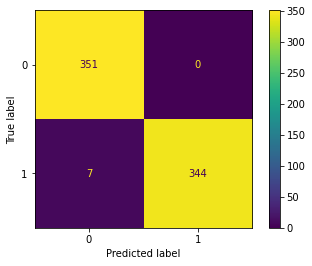

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Call the Naive Bayes algorithm, which we wrote ourselves
model = NaiveBayes()
model.fit(X_train,y_train) 
result = model.predict(X_train)
cm = confusion_matrix(y_train, result, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### 5) Checking the results on test set
The test set contains 130 spam emails and 130 non-spam emails. Please compute accuracy, recall, F-1 score to evaluate the performance of your spam filter.

In [31]:
########### Write Your Code Here ###########
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy import stats
def evaluate(model, algs_name='My Naive Bayes'):
    result = model.predict(X_test)
    print(f"accuracy={accuracy_score(y_test, result)}") 
    print(f"recall={recall_score(y_test, result)}") # 对垃圾邮件的敏感程度。出现一个垃圾邮件，检测出来的概率。
    print(f"f1={f1_score(y_test, result)}")
    cm = confusion_matrix(y_test, result, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    plt.figure()
    from sklearn.metrics import roc_curve
    proba = model.predict_proba(X_test)[:, 1]
    # proba = model.predict_log_proba(X_test)[:, 1]
    print(f"proba description:{stats.describe(proba)}")
    fpr, tpr, thresholds = roc_curve(y_test, proba, pos_label=1)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    # print(f'fpr={fpr}, ter={tpr}, thresholds={thresholds}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve for {algs_name}')
    plt.legend()
    plt.show()
############################################

accuracy=0.9807692307692307
recall=0.9615384615384616
f1=0.9803921568627451


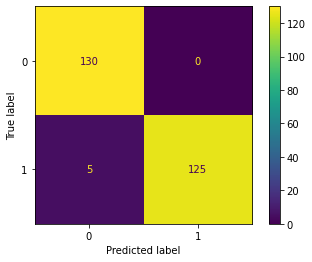

AttributeError: 'NaiveBayes' object has no attribute 'predict_log_proba'

<Figure size 432x288 with 0 Axes>

In [30]:
evaluate(model)

### Exercise 2 Compare your Naïve Bayes algorithm with GassianNB from Sklearn, which one does better? Where is the gap?

accuracy=0.9615384615384616
recall=0.9307692307692308
f1=0.9603174603174605


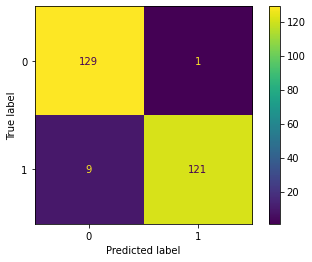

proba description:DescribeResult(nobs=260, minmax=(0.0, 1.0), mean=0.46923076923076923, variance=0.2500148500148501, skewness=0.12331063213729505, kurtosis=-1.984794488001901)


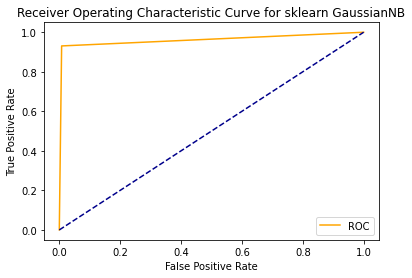

In [32]:
########### Write Your Code Here ###########
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
evaluate(clf, 'sklearn GaussianNB')
############################################

In [ ]:
import naive_bayes
clf = naive_bayes.GaussianNB()
clf.fit(X_train, y_train)
evaluate(clf, 'Imporved GaussianNB')

In [23]:
log = clf.predict_log_proba(X_test)[:, 1]
len(np.unique(log)), len(log)

(138, 260)

In [33]:
stats.describe(log)

DescribeResult(nobs=260, minmax=(-9822429085.857004, 0.0), mean=-669127228.963059, variance=2.1199640717970184e+18, skewness=-3.4835112019005625, kurtosis=13.664357381637018)

In [24]:
prob = clf.predict_proba(X_test)[:, 1]
len(np.unique(prob)), len(prob)

(2, 260)

答：我的朴素贝叶斯算法更好。因为我有一个参数epsilon可以调整，就是方差为0的时候，用特征总方差*epsilon代替。
我对这个参数进行了调参，让它训练集上表现最好，然后才到测试集上测试。而sklearn的GaussianNB我没有进行调参，所以默认参数没那么好。
我的proba用的是log后的，sklearn输出的是原本的概率。

accuracy=0.9615384615384616
recall=0.9307692307692308
f1=0.9603174603174605


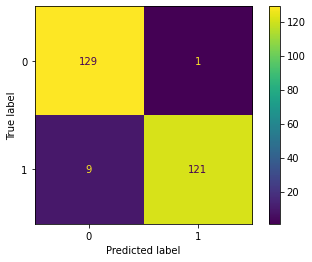

proba description:DescribeResult(nobs=260, minmax=(0.0, 1.0), mean=0.46923076923076923, variance=0.2500148500148501, skewness=0.12331063213729505, kurtosis=-1.984794488001901)


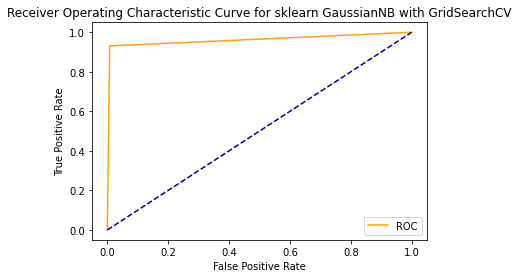

{'priors': [0.5, 0.5], 'var_smoothing': 1e-11}

In [ ]:
# 既然调参很重要，那么我们就来学习一下如何对sklearn进行调参，从而打败我1h写出来的朴素贝叶斯分类器。
# 首先查阅文档，发现sklearn的朴素贝叶斯分类器有一个参数，叫做var_smoothing，它的默认值是1e-9。
# sklearn是这样算的，所有的特征，不管类别，的最大方差*var_smoothing，就是0方差的修正方差。
# 我的算法是管类别的。
# 另一个参数是priors，它是一个列表，表示每个类别的先验概率，如果指定了，就不从数据中计算了。

from sklearn.model_selection import GridSearchCV
parameters = {'priors':[[0.5, 0.5], [0.6, 0.4], [0.7, 0.3], [0.8, 0.2]], 'var_smoothing':[1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 1e-3]}
gnb = GaussianNB()
clf = GridSearchCV(gnb, parameters, cv=5, n_jobs=8)
clf.fit(X_train, y_train)
evaluate(clf, 'sklearn GaussianNB with GridSearchCV')
clf.best_params_

accuracy=0.9615384615384616
recall=0.9307692307692308
f1=0.9603174603174605


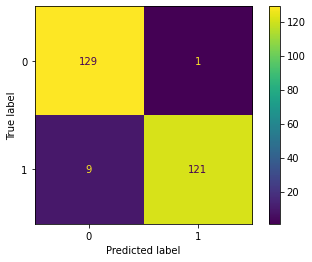

proba description:DescribeResult(nobs=260, minmax=(0.0, 1.0), mean=0.46923076923076923, variance=0.2500148500148501, skewness=0.12331063213729505, kurtosis=-1.984794488001901)


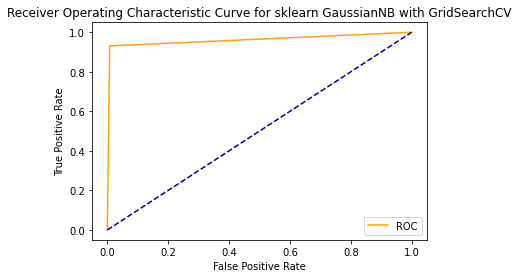

{'priors': [0.5, 0.5], 'var_smoothing': 5e-12}

In [ ]:
# 初步结论是先验还是不动比较好，然后var_smoothing 太大了不好。我们缩小搜索范围试试
parameters = {'priors':[[0.5, 0.5]], 'var_smoothing':[1e-12,5e-12, 1e-11, 5e-11, 1e-10, 1e-9]}
gnb = GaussianNB()
clf = GridSearchCV(gnb, parameters, cv=5, n_jobs=8)
clf.fit(X_train, y_train)
evaluate(clf, 'sklearn GaussianNB with GridSearchCV')
clf.best_params_

可惜的是，经过调参，sklearn还是打不过我。
很显然，sklearn的假设没有我的准确，sklearn假设0方差的变量的方差是所有特征中最大的那个方差。
我们可是有3000个特征啊，这个判断很武断！


我的假设是如果一个类别的一个特征的方差是0，我们先再同一个特征下考虑清楚，把方差设置为这个特征总的方差（两个类别都包括进来） 。如果真的总的方差都是0，那干脆别用这个这特征了，这个特征对于分类没有用。因为你也知道的，我们的求的概率在这个特征上做的决策，是两种类别下概率的相对比较而已，这个类别下两个概率都是0，那相当于没有这个特征，很有道理吧！


我的假设也有一定的不准确的，我没有考虑先验怎么影响他们的方差设计，但是比sklearn的假设还是好多了。我能不能用这个做一个科研呢，能不能发论文、给sklearn提交pr什么的？

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   16   | 9.80769E-01 | 9.80769E-01 | 7.69952E-01 | 5.07692E-01 | 1.65766E-01 
 1 |   32   | 9.80769E-01 | 9.80769E-01 | 9.25721E-01 | 8.19231E-01 | 6.48410E-02 
 2 |   48   | 9.80769E-01 | 9.80769E-01 | 9.71394E-01 | 9.61538E-01 | 9.11879E-03 
 3 |   64   | 9.80769E-01 | 9.80769E-01 | 9.80288E-01 | 9.76923E-01 | 1.27200E-03 
 4 |   80   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 5 |   96   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 6 |  112   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 7 |  128   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 8 |  144   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 9 |  160   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 10|

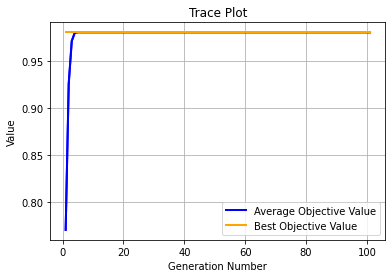

Execution time: 85.97232460975647 s
Evaluation number: 1616
The best objective value is: 0.9807692307692307
The best variables are: 
0.0	0.1	


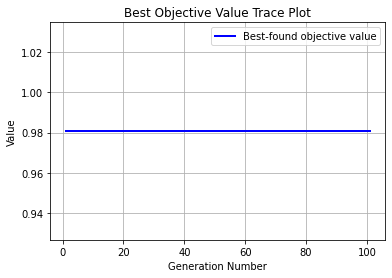

In [ ]:
# 公平起见，我的贝叶斯也要调参
# parameters = {'epsilon':[1e-12, 1e-11, 1e-10, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 1e1, 1e3]}
# nb = NaiveBayes()
# clf = GridSearchCV(nb, parameters, cv=5, n_jobs=8, scoring=)
# clf.fit(X_train, y_train)
# evaluate(clf, 'My NaiveBayes with GridSearchCV')
# clf.best_params_
# 改了半天，还是不符合sklearn的接口要求，我放弃了。
# 那我们别用sklearn网格调参了，使用我们系主任最擅长的演化计算来调参。
# 姚教授曾经用演化计算调整神经网络的机构，效果很好，发了一篇引用数量很高的论文。我们也来试试演化计算调节机器学习模型参数。
import geatpy as ea
# 构建问题
@ea.Problem.single
def evalVars(Vars):  # 定义目标函数（含约束）
    if Vars[0]==0: 
        model = NaiveBayes(epsilon=Vars[1])
    else:
        model = GaussianNB(var_smoothing=Vars[1])
    model.fit(X_train, y_train)
    result = model.predict(X_test)
    acc = accuracy_score(y_test, result)  # 注意y_true在前面，不要反了
    f = acc # 计算目标函数值, 要求最大值
    CV = 0 if Vars[1]!=0 else 2e9 # 约束
    return f, CV

# lb = [0, np.finfo(np.float32).min] # 2^-126 好像unnormalized可以更多。
# ub = [1, np.finfo(np.float32).max] # 2^128  
lb = [0, 1e-20]
ub = [1, 1e2] 
# lb = [1, np.finfo(np.float32).min] 
# ub = [1, np.finfo(np.float32).max] 
varTypes = [1, 0]
dim = 2
problem = ea.Problem(name='演化计算求解贝叶斯分类器参数',
                     M=1,  # 目标维数
                     maxormins=[-1],  # 目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标
                     Dim=dim,  # 决策变量维数
                     varTypes=varTypes,  # 决策变量的类型列表，0：实数；1：整数
                     lb=lb,  # 决策变量下界
                     ub=ub,  # 决策变量上界
                     evalVars=evalVars)
# 构建算法
algorithm = ea.soea_SEGA_templet(problem,
                                 ea.Population(Encoding='RI', NIND=16),
                                #  MAXGEN=80,  # 最大进化代数。
                                 MAXGEN=180,  # 最大进化代数。
                                 logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                 trappedValue=1e-8,  # 单目标优化陷入停滞的判断阈值。
                                 trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                 maxTrappedCount=100)  # 进化停滞计数器最大上限值。
                                #  maxTrappedCount=10)  # 进化停滞计数器最大上限值。
# 求解
res = ea.optimize(algorithm, prophet=np.array([[0, 1e-1],    # 我最好的参数
                                               [1, 5e-12], # sklearn最好的
                                               [1, 1e-8], # sklearn
                                               [1, 1e-9]]), # sklearn
                  seed=128, verbose=True, drawing=1, outputMsg=True, drawLog=True, saveFlag=True, dirName='result')

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   16   | 9.61538E-01 | 9.61538E-01 | 5.91346E-01 | 5.00000E-01 | 1.78440E-01 
 1 |   32   | 9.76923E-01 | 9.76923E-01 | 7.46154E-01 | 5.07692E-01 | 2.18081E-01 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 2 |   48   | 9.76923E-01 | 9.76923E-01 | 9.65385E-01 | 9.61538E-01 | 6.66173E-03 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 3 |   64   | 9.76923E-01 | 9.76923E-01 | 9.69231E-01 | 9.61538E-01 | 7.69231E-03 
 4 |   80   | 9.80769E-01 | 9.80769E-01 | 9.74279E-01 | 9.61538E-01 | 6.18961E-03 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 5 |   96   | 9.80769E-01 | 9.80769E-01 | 9.77644E-01 | 9.76923E-01 | 1.50120E-03 
 6 |  112   | 9.80769E-01 | 9.80769E-01 | 9.78606E-01 | 9.76923E-01 | 1.90799E-03 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 7 |  128   | 9.80769E-01 | 9.80769E-01 | 9.79567E-01 | 9.76923E-01 | 1.78274E-03 
 8 |  144   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 9 |  160   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 10|  176   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 11|  192   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 12|  208   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 13|  224   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 14|  240   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 15|  256   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 16|  272   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 17|  288   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 18|  304   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 19|  320   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 20|  336   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 21|  352   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 22|  368   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 23|  384   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 24|  400   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 25|  416   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 26|  432   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 27|  448   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 28|  464   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 29|  480   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 30|  496   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 31|  512   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 32|  528   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 33|  544   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 34|  560   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 35|  576   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 36|  592   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 37|  608   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 38|  624   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 39|  640   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 40|  656   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 41|  672   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 42|  688   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 43|  704   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 44|  720   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 45|  736   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 46|  752   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 47|  768   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 48|  784   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 49|  800   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 50|  816   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 51|  832   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 52|  848   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 53|  864   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 54|  880   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 55|  896   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 56|  912   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 57|  928   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 58|  944   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 59|  960   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 60|  976   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 61|  992   | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 62|  1008  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 63|  1024  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 64|  1040  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 65|  1056  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 66|  1072  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 67|  1088  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 68|  1104  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 69|  1120  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 70|  1136  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 71|  1152  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 72|  1168  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 73|  1184  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 74|  1200  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 75|  1216  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 76|  1232  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 77|  1248  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:486: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


 78|  1264  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 
 79|  1280  | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 9.80769E-01 | 0.00000E+00 


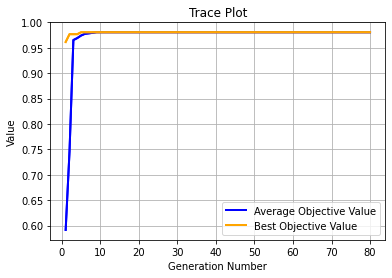

Execution time: 78.85021448135376 s
Evaluation number: 1280
The best objective value is: 0.9807692307692307
The best variables are: 
0.19999141693115235	0.00019073586328125002	


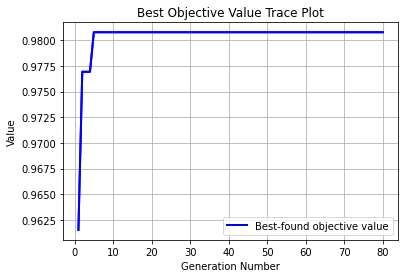

In [ ]:
# 可以看出，还是先验的那个参数好，其他参数都不好，根本打不过。
# 经过了100代的演化，sklearn还是没打过我。
# 这一次，我们专注于优化sklearn，把先验参数也纳入调参范围。
import geatpy as ea
# 构建问题
@ea.Problem.single
def evalVars(Vars):  # 定义目标函数（含约束）
    model = GaussianNB(priors=[Vars[0], 1-Vars[0]], var_smoothing=Vars[1])
    model.fit(X_train, y_train)
    result = model.predict(X_test)
    acc = accuracy_score(y_test, result)  # 注意y_true在前面，不要反了
    f = acc # 计算目标函数值, 要求最大值
    CV = 0 if Vars[1]!=0 else 2e9 # 约束
    return f, CV

lb = [0, 1e-20]
ub = [1, 1e2] 
varTypes = [0, 0]
dim = 2
problem = ea.Problem(name='演化计算求解贝叶斯分类器参数',
                     M=1,  # 目标维数
                     maxormins=[-1],  # 目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标
                     Dim=dim,  # 决策变量维数
                     varTypes=varTypes,  # 决策变量的类型列表，0：实数；1：整数
                     lb=lb,  # 决策变量下界
                     ub=ub,  # 决策变量上界
                     evalVars=evalVars)
# 构建算法
algorithm = ea.soea_SEGA_templet(problem,
                                 ea.Population(Encoding='RI', NIND=16),
                                 MAXGEN=80,  # 最大进化代数。
                                #  MAXGEN=180,  # 最大进化代数。
                                 logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                #  trappedValue=1e-8,  # 单目标优化陷入停滞的判断阈值。
                                 trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                 maxTrappedCount=100)  # 进化停滞计数器最大上限值。
                                #  maxTrappedCount=10)  # 进化停滞计数器最大上限值。
# 求解
res = ea.optimize(algorithm, prophet=np.array([[0.2, 1e-1],    
                                               [0.5, 5e-12], # sklearn最好的
                                               [0.7, 1e-8], 
                                               [0.9, 1e-9]]),
                  seed=128, verbose=True, drawing=1, outputMsg=True, drawLog=True, saveFlag=True, dirName='result')

accuracy=0.9807692307692307
recall=0.9615384615384616
f1=0.9803921568627451


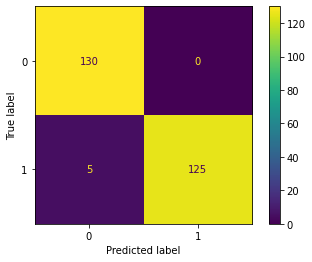

proba description:DescribeResult(nobs=260, minmax=(0.0, 1.0), mean=0.4817703890048901, variance=0.24988823427195142, skewness=0.07439598811495764, kurtosis=-1.9921746850555448)


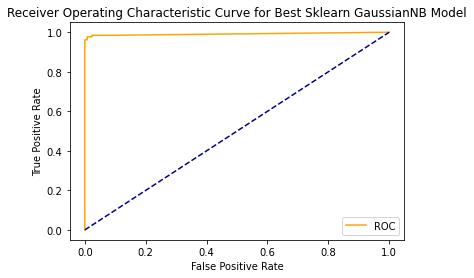

In [ ]:
Vars = [0.19999141693115235, 0.00019073586328125002]
model = GaussianNB(priors=[Vars[0], 1-Vars[0]], var_smoothing=Vars[1])
model.fit(X_train, y_train)
evaluate(model, 'Best Sklearn GaussianNB Model')

这一次，sklearn终于比我写的贝叶斯分类器厉害了！
我们的演化计算从数据中发现了规律！
我们发现了并不是像数据集说的，先验是0.5, 0.5，这个数据集可能在骗人。
实际上，这些邮件的总体，我们日常生活中的邮件，经过演化计算的发现，只有0.19999141693115235的概率是垃圾邮件。
明白了这一点之后，sklearn的分类器变得更加准确，ROC曲线非常好看！

### Exercise 3 Questions
1. Describe another real-world application where the naïve Bayes method can be applied

可以用来判别中国古诗词、电影评论、书评的情感，可能还可以判别中国古诗词的修辞手法、作者、体裁，判断新闻的真假。
既然自然语言处理可以，是不是也可以把音乐看成是一个语言，把图片看成是个语言，然后用朴素贝叶斯来判断呢？下次查查有没有人做过这个实验。

2. What are the strengths of the naïve Bayes method; when does it perform well?

优势：

- 参数很少，训练很快。
- 不需要保存训练数据，只需要对训练数据统计参数，所以占用内存不大。
- 对于缺失数据不敏感。
- 有坚实的概率论基础，数学公式是毋庸置疑的，唯一的问题是数据量不够。所以数据越多越好，不会过拟合。
- 适合多分类，不需要搞一对多、多对多什么的，直接求各个分类的概率就行了。

优势条件：
- 在已知类别的条件下，特征之间相互条件独立。
- 特征的分布和假设的分布，比如高斯分布，是大体一致的。也就是说样本来自的总体的分布类型和假设的分布没有太大的分歧。

3. What are the weaknesses of the naïve Bayes method; when does it perform poorly?

劣势条件和劣势：

- 如果特征之间相互依赖，那么就不是条件独立了，朴素假设就不合适了，数学公式失效。
- 数据量过少的时候，方差为0，导致概率为0，这个时候需要调参，参数比较玄学。
- 如果特征的分布和假设的分布不一致，那么就不合适了，数学公式失效。比如根本就不是高斯分布，而是指数分布，那么学了就学错了。
- 因为假设是高斯分布，所以对于outlier很敏感，如果有outlier，那么就会影响整体的分布，导致概率不准确。
- 太简单了，不够复杂，所以不够强大。不能像神经网络那样，自己学习特征，自己学习权重，自己学习模型。只能人为地指定特征，指定权重，指定模型。

4. What makes the naïve Bayes method a good candidate for the classification problem, if you have enough knowledge about the data?

如果我非常清楚数据的分布，甚至知道总体的概率分布的类型和参数，而且这个概率分布是图灵可计算的、算法复杂度是可以接受的，
那么似然概率的公式是完全可以准确计算的，这个时候我就可以用朴素贝叶斯，从数学上，它就是这种情况下最优的分类器，它估计的后验概率就是真的后验概率。根据decision theory，这样的分类器能最小化错误率。

所以，如果我知道数据的分布，那么我就可以用朴素贝叶斯，因为它是最优的分类器。

# 参考文献
[1] “Stop word,” Wikipedia. Sep. 21, 2022. Accessed: Sep. 29, 2022. [Online]. Available: https://en.wikipedia.org/w/index.php?title=Stop_word&oldid=1111514175

[2] “Numpy中stack()，hstack()，vstack()函数详解_neu_张康的博客-CSDN博客_hstack.” https://blog.csdn.net/csdn15698845876/article/details/73380803 (accessed Sep. 29, 2022).

[3] “高斯朴素贝叶斯（Gaussian Naive Bayes）原理与实现——垃圾邮件识别实战 - ISGuXing - 博客园.” https://www.cnblogs.com/ISGuXing/p/13777895.html (accessed Sep. 29, 2022).

[4] 周志华, 机器学习. 清华大学出版社, 2016. Accessed: Jul. 16, 2022. [Online]. Available: https://book.douban.com/subject/26708119/

[5] “融合高斯分布_Ronnie_Hu的博客-CSDN博客_融合高斯分布.” https://blog.csdn.net/Ronnie_Hu/article/details/111378283 (accessed Sep. 29, 2022).